# Data Wrangling: Acquisition & Preparation

In this lesson, we'll be acquiring and preparing some data from our SQL database.

## Learning Goals
    
- Acquire a sample of data from SQL.
- Identify null values, which nulls are 'deal-breakers', i.e. rows removed, which nulls should be represented by 0, and which should be replaced by a value from other methods, such as mean.		
- Identify outliers and decide what to do with them, if anything (remove, keep as-is, replace).
- Data Structure: Aggregate as needed so that every row is an observation and each column is a variable (1 variable and not a measure). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import acq

### Acquire & Summarize

In [2]:
df = acq.get_mallcustomer_data()

In [3]:
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [19]:
num_missing = df.isnull().sum(axis=1)
prnt_miss = num_missing / df.shape[1] * 100

In [20]:
prnt_miss

customer_id
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
196    0.0
197    0.0
198    0.0
199    0.0
200    0.0
Length: 200, dtype: float64

In [21]:
rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'perc_cols_missing': prnt_miss})

In [26]:
rows_missing.reset_index().groupby(['num_cols_missing', 'perc_cols_missing']).count().reset_index().rename(columns={'customer_id':'count'})

,num_cols_missing,perc_cols_missing,count
0,0,0.0,200


In [40]:
def nulls_by_row(df):
    num_missing = df.isnull().sum(axis=1)
    prnt_missing = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 
                                 'perc_cols_missing': prnt_missing}).\
    reset_index().groupby(['num_cols_missing', 
                           'perc_cols_missing']).\
    count().reset_index().rename(columns={'customer_id':'count'})
        
    return rows_missing

In [41]:
nulls_by_row(df)

,num_cols_missing,perc_cols_missing,count
0,0,0.0,200


In [42]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    prnt_missing = num_missing / df.shape[0] * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing,
                                'perc_rows_missing': prnt_missing})
    
    return cols_missing

In [43]:
nulls_by_col(df)

,num_rows_missing,perc_rows_missing
gender,0,0.0
age,0,0.0
annual_income,0,0.0
spending_score,0,0.0


In [80]:
def summarize(df):
    print('DataFrame head: ')
    print(df.head())
    print()
    print()
    print('DataFrame info: ')
    print(df.info())
    print()
    print()
    print('DataFrame describe: ')
    print(df.describe().T)
    print()
    print()
    print('DataFrame nulls by col: ', nulls_by_col(df))
    print()
    print()
    print('DataFrame nulls by row: ', nulls_by_row(df))
    print()
    print()
    nums = [col for col in df.columns if df[col].dtype != 'O']
    cats = [col for col in df.columns if col not in nums]
    print('Value Counts: ')
    for col in df.columns:
        print('Column Name: '+ col)
        if col in cats:
            print(df[col].value_counts())
            print()
        else:
            print(df[col].value_counts(bins=10, sort=False))
            print()
    print()
    print()
    print()
    print('Report Finished')

In [81]:
summarize(df)

DataFrame head: 
             gender  age  annual_income  spending_score
customer_id                                            
1              Male   19             15              39
2              Male   21             15              81
3            Female   20             16               6
4            Female   23             16              77
5            Female   31             17              40


DataFrame info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.9+ KB
None


DataFrame describe: 
                count   mean        std   min    25%   50%   75%    max
age             200.0  38.85  13.969007  18.0  28.75 

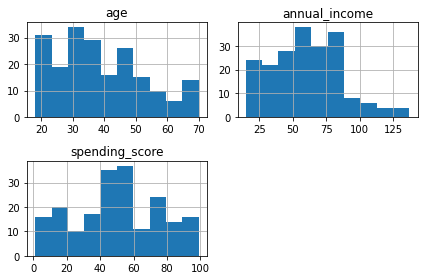

In [69]:
df.hist()
plt.tight_layout()
plt.show()

In [74]:
def get_upper_outliers(s, k=1.5):
    '''
    Take in a series and 
    '''
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper = q3 + k*iqr
    # lower = q1 - k*iqr
    return s.apply(lambda x: max([x - upper, 0]))

In [75]:
def add_upper_outlier_col(df, k=1.5):
    for col in df.select_dtypes('number'):
        df[col + '_upper_outliers'] = get_upper_outlier(df[col])
    return df

In [76]:
def get_lower_outliers(s, k=1.5):
    '''
    Take in a series and 
    '''
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    # upper = q3 + k*iqr
    lower = q1 - k*iqr
    return s.apply(lambda x: min([x + lower, 0]))

In [78]:
def remove_columns(df, cols_to_remove):
    df = df.drop(columns=cols_to_remove)
    return df

In [79]:
def handle_missing_values(df, prop_req_cols=0.5, prop_req_rows=0.75):
    threshold = int(round(prop_req_cols * len(df.shape[0]), 0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_req_rows * len(df.shape[1]), 0))
    df = df.dropna(axis=0, thresh=threshold)

In [77]:
get_lower_outliers(df.annual_income)

customer_id
1      0
2      0
3      0
4      0
5      0
      ..
196    0
197    0
198    0
199    0
200    0
Name: annual_income, Length: 200, dtype: int64